In [1]:
pip install symforce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 1.5 MB 42.1 MB/s 
     |████████████████████████████████| 82 kB 350 kB/s 
     |████████████████████████████████| 70 kB 4.1 MB/s 
     |████████████████████████████████| 1.5 MB 49.5 MB/s 
     |████████████████████████████████| 6.5 MB 29.0 MB/s 
     |████████████████████████████████| 49 kB 3.1 MB/s 
     |████████████████████████████████| 96 kB 2.9 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: sympy
    Found existing installation: sympy 1.7.1
    Uninstalling sympy-1.7.1:
      Successfully uninstalled sympy-1.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followi

In [2]:
import symforce

symforce.set_epsilon_to_symbol()

# -----------------------------------------------------------------------------
# Import Library
# -----------------------------------------------------------------------------
import numpy as np

from symforce import typing as T
from symforce.values import Values
import symforce.symbolic as sf


In [3]:

def build_initial_values() -> T.Tuple[Values, int, int]:
  
    num_poses = 3
    num_landmarks = 3

    initial_values = Values(
        poses=[sf.Pose2.identity()] * num_poses,
        landmarks=[sf.V2(-2, 2), sf.V2(1, -3), sf.V2(5, 2)],
        distances=[1.7, 1.4],
        angles=np.deg2rad([[55, 245, -35], [95, 220, -20], [125, 220, -20]]).tolist(),
        epsilon=sf.numeric_epsilon,
    )

    return initial_values, num_poses, num_landmarks

In [4]:
def bearing_residual(
    pose: sf.Pose2, landmark: sf.V2, angle: sf.Scalar, epsilon: sf.Scalar
) -> sf.V1:

    t_body = pose.inverse() * landmark
    predicted_angle = sf.atan2(t_body[1], t_body[0], epsilon=epsilon)
    return sf.V1(sf.wrap_angle(predicted_angle - angle))


In [5]:
def odometry_residual(
    pose_a: sf.Pose2, pose_b: sf.Pose2, dist: sf.Scalar, epsilon: sf.Scalar
) -> sf.V1:
   
    return sf.V1((pose_b.t - pose_a.t).norm(epsilon=epsilon) - dist)


from symforce.opt.factor import Factor


In [6]:
def build_factors(num_poses: int, num_landmarks: int) -> T.Iterator[Factor]:
   
    for i in range(num_poses - 1):
        yield Factor(
            residual=odometry_residual,
            keys=[f"poses[{i}]", f"poses[{i + 1}]", f"distances[{i}]", "epsilon"],
        )

    for i in range(num_poses):
        for j in range(num_landmarks):
            yield Factor(
                residual=bearing_residual,
                keys=[f"poses[{i}]", f"landmarks[{j}]", f"angles[{i}][{j}]", "epsilon"],
            )


In [7]:
from symforce.opt.optimizer import Optimizer


def main() -> None:
    initial_values, num_poses, num_landmarks = build_initial_values()

    factors = build_factors(num_poses=num_poses, num_landmarks=num_landmarks)

    optimized_keys = [f"poses[{i}]" for i in range(num_poses)]

    optimizer = Optimizer(
        factors=factors,
        optimized_keys=optimized_keys,
        debug_stats=True,  # Return problem stats for every iteration
        params=Optimizer.Params(verbose=True),  # Customize optimizer behavior
    )

    result = optimizer.optimize(initial_values)

    print(f"Num iterations: {len(result.iteration_stats) - 1}")
    print(f"Final error: {result.error():.6f}")

    for i, pose in enumerate(result.optimized_values["poses"]):
        print(f"Pose {i}: t = {pose.position()}, heading = {pose.rotation().to_tangent()[0]}")

    from symforce.examples.robot_2d_localization.plotting import plot_solution

    plot_solution(optimizer, result)



In [8]:
import shutil
from pathlib import Path

# -----------------------------------------------------------------------------
# (Optional) Generate C++ functions for residuals with on-manifold jacobians
# -----------------------------------------------------------------------------
from symforce.codegen import Codegen
from symforce.codegen import CppConfig


def generate_bearing_residual_code(output_dir: Path = None, print_code: bool = False) -> None:
    """
    Generate C++ code for the bearing residual function. A C++ Factor can then be
    constructed and optimized from this function without any Python dependency.
    """
    # Create a Codegen object for the symbolic residual function, targeted at C++
    codegen = Codegen.function(bearing_residual, config=CppConfig())

    # Generate the function and print the code
    metadata = codegen.generate_function(output_dir=output_dir, skip_directory_nesting=True)
    if print_code:
        print(metadata.generated_files[0].read_text())

    if output_dir is None:
        shutil.rmtree(metadata.output_dir)

    # Create a Codegen object that computes a linearization from the residual Codegen object,
    # by introspecting and symbolically differentiating the given arguments
    codegen_with_linearization = codegen.with_linearization(which_args=["pose"])

    # Generate the function and print the code
    metadata = codegen_with_linearization.generate_function(
        output_dir=output_dir, skip_directory_nesting=True
    )
    if print_code:
        print(metadata.generated_files[0].read_text())

    if output_dir is None:
        shutil.rmtree(metadata.output_dir)


In [9]:
def generate_odometry_residual_code(output_dir: Path = None, print_code: bool = False) -> None:
    """
    Generate C++ code for the odometry residual function. A C++ Factor can then be
    constructed and optimized from this function without any Python dependency.
    """
    # Create a Codegen object for the symbolic residual function, targeted at C++
    codegen = Codegen.function(odometry_residual, config=CppConfig())

    # Generate the function and print the code
    metadata = codegen.generate_function(output_dir=output_dir, skip_directory_nesting=True)
    if print_code:
        print(metadata.generated_files[0].read_text())

    if output_dir is None:
        shutil.rmtree(metadata.output_dir)

    # Create a Codegen object that computes a linearization from the residual Codegen object,
    # by introspecting and symbolically differentiating the given arguments
    codegen_with_linearization = codegen.with_linearization(which_args=["pose_a", "pose_b"])

    # Generate the function and print the code
    metadata = codegen_with_linearization.generate_function(
        output_dir=output_dir, skip_directory_nesting=True
    )
    if print_code:
        print(metadata.generated_files[0].read_text())

    if output_dir is None:
        shutil.rmtree(metadata.output_dir)

Num iterations: 8
Final error: 0.000220
Pose 0: t = [[-0.58303818]
 [-0.82449079]], heading = [1.073486]
Pose 1: t = [[ 1.01671023]
 [-0.23835618]], heading = [0.85760621]
Pose 2: t = [[1.79784992]
 [0.92055145]], heading = [0.67637098]


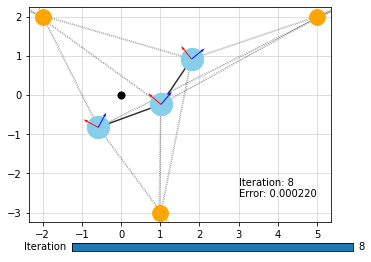

In [10]:
if __name__ == "__main__":
    main()